2023/01/08

- ノイズ除去
  - ガウシアンノイズ
    - 品質測定
  - 平均値フィルタ
  - 中央値フィルタ
  - 畳み込みフィルタ
    - 加重平均値フィルタ
  - ガウシアンフィルタ
  - バイラテラルフィルタ
  - Non-local meansフィルタ
- 輪郭抽出
  - 微分フィルタ
    - Prewittフィルタ
    - Sobelフィルタ
    - Laplacianフィルタ
  - メキシカンハットフィルタ
  - Gaborフィルタ
  - 周波数フィルタ

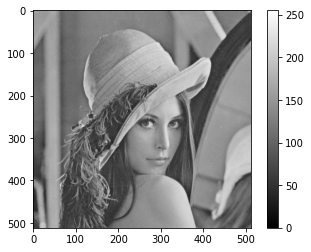

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# NumPy配列として読み込まれる．ついでにRGBの平均でグレースケール化．
img = plt.imread("./data/lena.jpg").mean(2)
plt.imshow(img, "gray", vmin=0, vmax=255)
plt.colorbar()

# ノイズ除去 denoising; noise reduction

## ガウシアンノイズ Gaussian noise
- 各画素に対し，正規分布に従う乱数を加える．
- フィルタリングの大きな目的は，こうしたノイズをできる限り除去して元画像を推定すること．

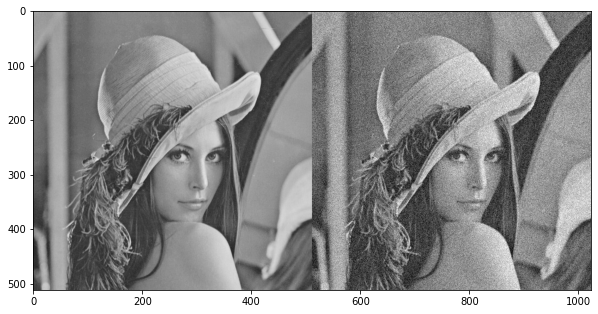

In [2]:
img_n = img + np.random.normal(0, 20, img.shape)
img_n = np.minimum(255, np.maximum(0, img_n))   # 0以上255以下に正規化
plt.figure(figsize=(10, 6))
plt.imshow(np.c_[img, img_n], "gray")           # 元画像と並べて表示

### 品質評価
- ノイズを除去した画像がどれくらい元画像に近いか？
- 定量的に評価する指標：平均二乗誤差(MSE), ピーク信号対雑音比 (peak signal-to-noize ratio; PSNR)

$$
MSE \stackrel{\text{def}}{=} \frac{1}{mn} \sum_{\substack{0 \le i \lt m \\ 0 \le j \lt n}} (x_{i, j} - y_{i, j})^2 > 0 \\
PSNR \stackrel{\text{def}}{=} 10 \log_{10} \frac{MAX^2}{MSE} = 20 \log_{10} \frac{MAX}{\sqrt{MSE}} \in \mathbb{R}
$$
- 画像を $\bm{X}, \bm{Y} \in \mathbb{R}^{m \times n}$ で表す．
  - 添字は画像配列のインデックスで，0ベースとする．
  - $x_{i, j}$: 画像 $X$ の画素 `x[i, j]`
  - $y_{i, j}$: 画像 $Y$ の画素 `y[i, j]`
  - $MAX$: 画素が取りうる最大値．uint8なら255，正規化されていれば1．
- MSE: 各画素の差の二乗の平均．同一画像なら0．
- PSNR: デシベル変換したもの．高いほど類似する．

In [3]:
def MSE(img1, img2):
    return np.mean((img1 - img2) ** 2)

def PSNR(img1, img2):
    return 20 * np.log10(255 / np.sqrt(MSE(img1, img2)))

In [4]:
# ノイズ画像と元画像の比較
print(MSE(img, img_n))
print(PSNR(img, img_n))

399.9689884163692
22.110540412443456


## 平均値フィルタ means filter
各画素について，周辺の画素の平均を取ることでぼかしの効果が出る．

1次元
$$
y_i \stackrel{\text{def}}{=} \frac{1}{2r+1} \sum_{\varDelta_i = -r}^{r} x_{i+\varDelta_i}
$$

2次元
$$
y_{i, j} \stackrel{\text{def}}{=} \frac{1}{(2r+1)^2} \sum_{\varDelta_i = -r}^{r} \sum_{\varDelta_j = -r}^{r} x_{i+\varDelta_i, j+\varDelta_j}
$$
- $r$: 周辺領域の半径（フィルタ半径）．注目画素から何画素離れたところまで見るか．
  - 一般に縦横で変える場合も考えられるが，ここでは正方形領域とする．
  - 領域内の1つの軸方向の画素数は $2r+1$ となる．当然2次元領域の画素数は $(2r+1)^2$ となる．

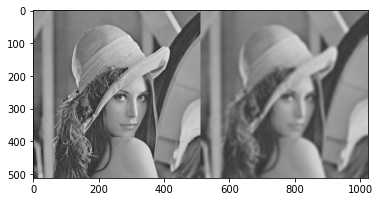

In [5]:
r = 5
h, w = img.shape
# パディング：端の画素は近傍画素を持たないので，事前にパディングしておく．
img_pad = np.pad(img, r, "reflect")
img_means = np.array([[img_pad[i-r:i+r+1, j-r:j+r+1].mean() for j in range(r, w+r)] for i in range(r, h+r)])
plt.imshow(np.c_[img, img_means], "gray", vmin=0, vmax=255)

局所領域を並べた配列を使うと，for文の回数が減り，Pythonではかなり高速化できる．

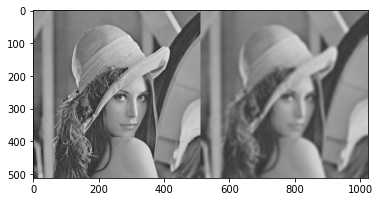

In [6]:
r = 5
h, w = img.shape
img_pad = np.pad(img, r, "reflect")
# 局所領域配列 F: (2r+1, 画素数)
F = np.array([img_pad[i:h+i, j:w+j].flatten() for i in range(2*r+1) for j in range(2*r+1)])
img_means = F.mean(0).reshape(h, w)
plt.imshow(np.c_[img, img_means], "gray", vmin=0, vmax=255)

ノイズ画像に対して行うと，ノイズのある画素のノイズは小さくなるが，他の画素にノイズが滲んでしまう．

177.35796816738824
25.642296560588733


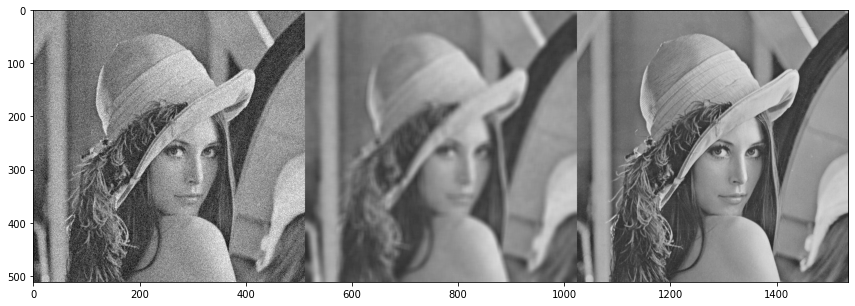

In [15]:
img_pad = np.pad(img_n, r, "reflect")
F = np.array([img_pad[i:h+i, j:w+j].flatten() for i in range(2*r+1) for j in range(2*r+1)])
img_means = F.mean(0).reshape(h, w)

# 品質は改善している．
print(MSE(img, img_means))
print(PSNR(img, img_means))
# ノイズ画像，フィルタ画像，元画像
plt.figure(figsize=(15, 5))
plt.imshow(np.c_[img_n, img_means, img], "gray")

## 中央値フィルタ median filter
- ノイズは一般に，全部の画素に出現するわけではなく，カメラの特性などが原因で一部の画素に対してのみ強く出る（インパルスノイズ）．
- 平均値の代わりに中央値を使うことで，一部の外れ値の影響を軽減できる．

142.11949549087188
26.604267037472095


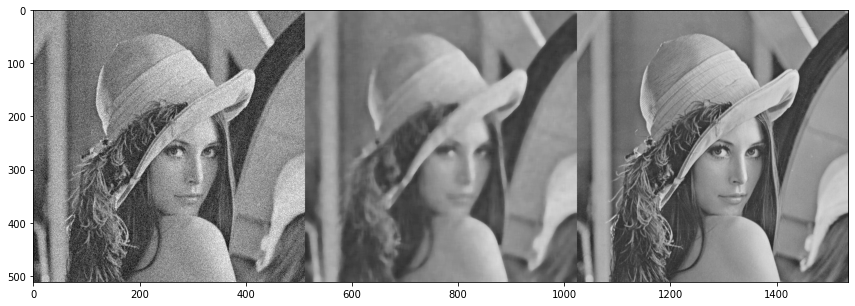

In [16]:
img_pad = np.pad(img_n, r, "reflect")
F = np.array([img_pad[i:h+i, j:w+j].flatten() for i in range(2*r+1) for j in range(2*r+1)])
img_median = np.median(F, 0).reshape(h, w)

# 少し改善
print(MSE(img, img_median))
print(PSNR(img, img_median))
plt.figure(figsize=(15, 5))
plt.imshow(np.c_[img_n, img_median, img], "gray")

## 画像畳み込み image convolution
平均値フィルタは周辺画素の平均を取るが，小さな重みフィルタ（カーネル）を使えばより柔軟なフィルタリングができる．

1次元
$$
y_{i} \stackrel{\text{def}}{=} \sum_{\varDelta_i} w_{r+\varDelta_i} \ x_{i+\varDelta_i}
$$

2次元
$$
y_{i, j} \stackrel{\text{def}}{=} \sum_{\varDelta_i, \varDelta_j} w_{r+\varDelta_i, r+\varDelta_j} \ x_{i+\varDelta_i, j+\varDelta_j}
$$

- $w$: フィルタカーネルの重み．添字はインデックス．
- めんどっちいので略記したが，$-r \le \varDelta_i \le r, -r \le \varDelta_j \le r$ でそれぞれすべての組み合わせの総和である．
- 信号処理における畳み込みの本来の定義は入力信号を反転させてから掛け合わせるものだが，もはやそんなこと気にしてる人は殆どいない．
- 線形フィルタとも言う．

### 加重平均値フィルタ weighted mean filter
- 畳み込むだけだと重みによっては画素値がすごいことになりそうなので，重み付き平均にする．
- ⇔画素値を重みの和で割る．
- ⇔重みを重みの和で割る．
- ⇔重みの和が1になる．

$$
w_{r+\varDelta_i, r+\varDelta_j} \gets \frac{w_{r+\varDelta_i, r+\varDelta_j}}{\sum_{\varDelta_i, \varDelta_j} w_{r+\varDelta_i, r+\varDelta_j}} \\
\Leftrightarrow \sum_{\varDelta_i, \varDelta_j} w_{r+\varDelta_i, r+\varDelta_j} = 1
$$
- 平均値フィルタは $\forall w = 1$ の加重平均値フィルタと等価．
- 中央値フィルタは畳み込みでは表現できない．
- 重みの和は重みを実数関数で表して積分することで計算できるし，カーネル作成後に和を取って割っても良い．
  - ただし後者は離散値のため微妙に誤差が生じる．
  - 逆に前者で作ったカーネルの総和はちょうど1にはならない．

In [9]:
def conv2d(img, knl):
    h_img, w_img = img.shape
    h_knl, w_knl = knl.shape
    img = np.pad(img, ((h_knl, h_knl), (w_knl, w_knl)), mode="reflect")
    F = [img[i:i+h_img, j:j+w_img].flatten() for i in range(h_knl) for j in range(w_knl)]
    return (knl.flatten() @ F).reshape(h_img, w_img)

## ガウシアンフィルタ Gaussian filter
中心から離れるほど重みが小さくなる加重平均値フィルタ．

1次元
$$
w_{r+\varDelta_i} = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{\varDelta_i^2}{2\sigma^2} \right)
$$

2次元
$$
w_{r+\varDelta_i, r+\varDelta_j} = \frac{1}{2\pi\sigma^2} \exp \left( -\frac{\varDelta_i^2+\varDelta_j^2}{2\sigma^2} \right)
$$

- $\sigma^2$: 重みの分散
- $\frac{1}{2\pi\sigma^2}$ は重みの和に対応する．指数部分を実数空間で積分するとこれになる．というかガウス関数として有名．
- 平均値フィルタに対し，注目画素を優先するように改良したとも言える．
- ぼかしの効果もあり，ガウシアンぼかし (Gaussian blur) とも呼ばれる．

0.9955148349824938


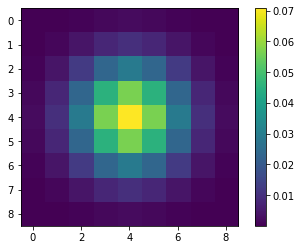

In [10]:
def gaussian_kernel(r=4, s=1.5):
    di, dj = np.meshgrid(*np.c_[-r:r+1, -r:r+1].T)
    return np.exp(-(di**2+dj**2)/(2*s**2)) / (2*np.pi*s**2)

knl_gauss = gaussian_kernel()

print(knl_gauss.sum())  # 重みの和はほぼ1になっている．
plt.imshow(knl_gauss)
plt.colorbar()

812.1912616704617
19.034220482437057


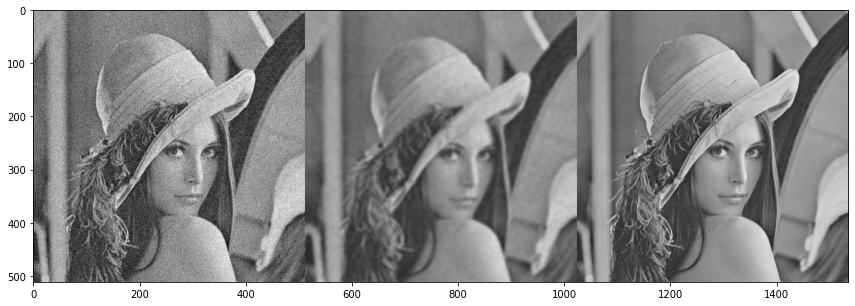

In [17]:
knl_gauss = gaussian_kernel(5, 2.3)
img_gauss = conv2d(img_n, knl_gauss)
plt.figure(figsize=(15, 5))
plt.imshow(np.c_[img_n, img_gauss, img], "gray")
# ノイズ除去としては微妙
print(MSE(img, img_gauss))
print(PSNR(img, img_gauss))

## バイラテラルフィルタ bilateral filter

$$
w_{i, j, r+\varDelta_i, r+\varDelta_j} = \exp \left( -\frac{\varDelta_i^2+\varDelta_j^2}{2\sigma_1^2} \right) \exp \left( -\frac{(x_{i, j}-x_{i+\varDelta_i, j+\varDelta_j})^2}{2\sigma_2^2} \right)
$$

## Non-local means filter 非局所平均値フィルタ
- [Buades, Antoni, Bartomeu Coll, and J-M. Morel. "A non-local algorithm for image denoising." 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05). Vol. 2. Ieee, 2005.](https://doi.org/10.1109/CVPR.2005.38)
- 周辺領域が類似するような画素を探し，平均を取る．

# 輪郭抽出

## 微分フィルタ

## メキシカンハットフィルタ
2つのガウシアンフィルタの線形差分

$$
w = k_1 w_1 - k_2 w_2
$$
- $w_1, w_2$: 異なるガウシアンフィルタ
- $k_1, k_2$: 係数

## Gabor フィルタ

## 周波数フィルタ